In [ ]:
# ==========================================
# SCRIPT KOREKSI BIAS: LINEAR SCALING
# ==========================================
# Penulis: Mahasiswa Geografi Lingkungan
# Metode: Linear Scaling Time-Variant (Dynamic Ratio per Month)
# ==========================================

# 1. INSTALL LIBRARY
!pip install rasterio geopandas shapely matplotlib scikit-learn pandas numpy seaborn tqdm folium

import os
import glob
import numpy as np
import pandas as pd
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from google.colab import drive
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

In [ ]:
# ==========================================
# BAGIAN 1: SETUP & KONFIGURASI
# ==========================================

# Mount Google Drive
drive.mount('/content/drive')

# --- DIREKTORI DATA (SESUAIKAN PATH INI) ---
BASE_DIR = '/content/drive/My Drive/Colab Notebooks/Skripsi/'
CHIRPS_DIR = os.path.join(BASE_DIR, 'CHIRPS v3/')
ADMIN_PATH = os.path.join(BASE_DIR, 'Batas Adm Jambi/Adm_Jambi_Prov.shp')
CSV_DIR = os.path.join(BASE_DIR, 'Data Stasiun BWS Sumatera VI/')

# Output Directory (Folder Baru untuk Linear Scaling)
output_dir = os.path.join(CHIRPS_DIR, 'bias_corrected_scaling')
os.makedirs(output_dir, exist_ok=True)

# Rentang wilayah (Bounding Box Jambi)
bbox = box(100.75, -2.75, 104.75, -0.5)
bbox_gdf = gpd.GeoDataFrame({'geometry': [bbox]}, crs='EPSG:4326')

# --- DAFTAR STASIUN ---
# 1. Stasiun Kalibrasi (Digunakan untuk menghitung Faktor Skala)
bias_stations = [
    "Koto Limau Sering", "Semurup", "Sipin", "Siulak Deras",
    "Dendang", "Pulau Tengah", "Tamiai"
]

# 2. Stasiun Validasi (Digunakan untuk menguji hasil)
validation_stations = [
    "Bukit Bulan",
    "Muara Tembesi",
    "Rantau Pandan",
    "Sungai Manau",
    "Tanjung Genting",
    "Muaro Imat",
    "Sungai Bengkal"
]

# Lokasi Koordinat Stasiun (Longitude/X, Latitude/Y)
station_coords = {
    "Koto Limau Sering": (101.366300, -2.063383),
    "Semurup": (101.378350, -2.001750),
    "Sipin": (103.596750, -1.610600),
    "Siulak Deras": (101.297850, -1.936050),
    "Dendang": (103.948100, -1.190800),
    "Pulau Tengah": (101.463533, -2.169750),
    "Tamiai": (101.643800, -2.186933),
    "Batang Asai": (102.285631, -2.492758),
    "Biuku Tanjung": (102.201683, -2.123467),
    "Bukit Bulan": (102.639417, -2.517517),
    "Hiang": (101.477800, -2.074217),
    "Jujuhan": (101.766217, -1.328300),
    "Kersik Tuo": (101.282533, -1.779867),
    "Pulau Musang": (102.100717, -1.157717),
    "Mess Bungo": (102.330650, -1.494717),
    "Muara Jernih": (102.166800, -1.950067),
    "Muara Tembesi": (103.127017, -1.719333),
    "Pulau Lintang": (102.592700, -2.280883),
    "Rantau Pandan": (101.968817, -1.621217),
    "Rimbo Bujang": (102.088833, -1.319517),
    "Senamat": (102.330650, -1.643583),
    "Suak Kandis": (104.053117, -1.374000),
    "Sungai Manau": (101.983400, -2.114817),
    "Tanjung Genting": (103.161200, -1.938300),
    "Durian Luncuk": (102.995683, -1.880150),
    "Gapura Suci": (102.285383, -1.699950),
    "Lempur": (101.627683, -2.248867),
    "Muaro Imat": (101.719850, -2.225333),
    "Pamenang": (102.512817, -2.112200),
    "Pasir Putih": (103.643200, -1.622550),
    "Pauh": (102.820633, -2.133417),
    "Sungai Bengkal": (102.723933, -1.550633),
    "Singkut": (102.713633, -2.506200)
}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ==========================================
# BAGIAN 2: FUNGSI UTILITAS (SAMA SEPERTI SEBELUMNYA)
# ==========================================

def clip_raster_to_bbox(input_path, bbox_geom):
    with rasterio.open(input_path) as src:
        out_image, out_transform = mask(src, bbox_geom.geometry, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
    return out_image[0], out_meta

def extract_chirps_at_point(raster, transform, lon, lat):
    row, col = rasterio.transform.rowcol(transform, lon, lat)
    try:
        val = raster[row, col]
        return val if val != -9999 else np.nan
    except IndexError:
        return np.nan

def load_station_csv(csv_dir):
    bulan_mapping = {'Januari': '01', 'Februari': '02', 'Maret': '03', 'April': '04',
                     'Mei': '05', 'Juni': '06', 'Juli': '07', 'Agustus': '08',
                     'September': '09', 'Oktober': '10', 'November': '11', 'Desember': '12'}
    station_data = {}
    csv_files = glob.glob(os.path.join(csv_dir, '*.csv'))

    if not csv_files:
        print("[ERROR] Tidak ada file CSV ditemukan!")
        return {}

    for csv_file in csv_files:
        nama = os.path.basename(csv_file).replace('.csv', '')
        try:
            df = pd.read_csv(csv_file, index_col=0)
            df.replace("-", np.nan, inplace=True)
            df = df.apply(pd.to_numeric, errors='coerce')
            df = df.stack().reset_index()
            df.columns = ['Bulan', 'Tahun', 'CurahHujan']
            df['BulanAngka'] = df['Bulan'].map(bulan_mapping)
            df['Tanggal'] = pd.to_datetime(df['Tahun'].astype(str) + "-" + df['BulanAngka'] + "-01")
            df.set_index('Tanggal', inplace=True)
            station_data[nama] = df[['CurahHujan']].sort_index()
        except Exception as e:
            print(f"[WARNING] Gagal membaca {nama}: {e}")
    return station_data

In [ ]:
# ==========================================
# BAGIAN 3: PROSES UTAMA (MODIFIKASI: LINEAR SCALING)
# ==========================================

# Load Data
print("--- Memuat Data ---")
station_data = load_station_csv(CSV_DIR)
chirps_files = sorted(glob.glob(os.path.join(CHIRPS_DIR, 'chirps-v3.0.*.tif')))
validasi_df = pd.DataFrame()

print(f"Total file CHIRPS ditemukan: {len(chirps_files)}")

# Loop File Raster (Per Bulan)
for file_path in tqdm(chirps_files, desc="Proses Koreksi Linear Scaling"):
    filename = os.path.basename(file_path)

    try:
        parts = filename.split('.')
        date_str = f"{parts[2]}-{parts[3]}-01"
        date = pd.to_datetime(date_str)
    except IndexError:
        continue

    # 1. Baca raster
    try:
        raster, meta = clip_raster_to_bbox(file_path, bbox_gdf)
    except Exception as e:
        print(f"Error reading raster {filename}: {e}")
        continue

    # 2. TRAINING: Ambil data pasangan (Satelit vs Obs) di Stasiun Kalibrasi
    X_sat = []
    y_obs = []

    for stasiun in bias_stations:
        if stasiun in station_data:
            try:
                obs_val = station_data[stasiun].reindex([date])['CurahHujan'].values[0]
                if not np.isnan(obs_val):
                    lon, lat = station_coords[stasiun]
                    sat_val = extract_chirps_at_point(raster, meta['transform'], lon, lat)
                    if not np.isnan(sat_val) and sat_val >= 0:
                        X_sat.append(sat_val)
                        y_obs.append(obs_val)
            except KeyError:
                continue

    # 3. MENGHITUNG SCALING FACTOR (Rasio Rata-Rata)
    # Factor = Mean(Obs) / Mean(Sat)

    scaling_factor = 1.0 # Default jika data tidak cukup (tidak dikoreksi)

    if len(X_sat) >= 1: # Minimal 1 stasiun untuk scaling (lebih baik >2)
        mean_obs = np.mean(y_obs)
        mean_sat = np.mean(X_sat)

        # Hindari pembagian dengan nol
        if mean_sat > 0:
            scaling_factor = mean_obs / mean_sat
        else:
            # Jika satelit mendeteksi 0 hujan rata-rata, scaling factor tidak bisa dihitung.
            # Opsinya: Tetapkan 1 atau 0. Di sini kita tetapkan 1 (tidak diubah).
            scaling_factor = 1.0

    # 4. TERAPKAN KOREKSI KE RASTER
    # P_corrected = P_raw * Scaling_Factor
    corrected_raster = raster * scaling_factor

    # Pastikan tidak ada nilai negatif (sebenarnya perkalian tidak akan menghasilkan negatif jika input positif)
    corrected_raster = np.maximum(corrected_raster, 0)

    # 5. SIMPAN RASTER TERKOREKSI (Opsional)
    # meta.update(dtype='float32')
    # outname = f'chirps-v3.0.{date.year:04d}.{date.month:02d}.scaled_corrected.tif'
    # outpath = os.path.join(output_dir, outname)
    # with rasterio.open(outpath, 'w', **meta) as dst:
    #     dst.write(corrected_raster.astype('float32'), 1)

    # 6. VALIDASI: Cek akurasi di Stasiun Validasi
    for stasiun in validation_stations:
        obs_val = np.nan
        raw_val = np.nan
        corr_val = np.nan

        # Ambil Observasi
        if stasiun in station_data:
            try:
                val = station_data[stasiun].reindex([date])['CurahHujan'].values[0]
                if not np.isnan(val):
                    obs_val = val
            except:
                pass

        # Ambil Satelit
        if stasiun in station_coords:
            lon, lat = station_coords[stasiun]
            raw_val = extract_chirps_at_point(raster, meta['transform'], lon, lat)
            corr_val = extract_chirps_at_point(corrected_raster, meta['transform'], lon, lat)

        # Simpan ke DataFrame
        if not (np.isnan(obs_val) and np.isnan(raw_val)):
            entry = pd.DataFrame([{
                "Stasiun": stasiun,
                "Tanggal": date,
                "Observed": obs_val,
                "Raw": raw_val,
                "Corrected": corr_val,
                "Scaling_Factor": scaling_factor
            }])
            validasi_df = pd.concat([validasi_df, entry], ignore_index=True)

# Simpan Data Mentah
validasi_df.sort_values(['Stasiun', 'Tanggal'], inplace=True)
validasi_df.to_csv(os.path.join(output_dir, 'validasi_scaling_raw.csv'), index=False)
print("Looping selesai.")

--- Memuat Data ---
Total file CHIRPS ditemukan: 144


Proses Koreksi Linear Scaling: 100%|██████████| 144/144 [00:24<00:00,  5.77it/s]

Looping selesai.


In [ ]:
# ==========================================
# BAGIAN 4: HITUNG METRIK STATISTIK (NSE, R, RSR)
# ==========================================

print("\n--- Menghitung Indikator Statistik ---")

final_metrics = []

for stasiun in validation_stations:
    subset = validasi_df[validasi_df['Stasiun'] == stasiun]

    stats = {
        "Stasiun": stasiun,
        "NSE_Raw": np.nan, "NSE_Corrected": np.nan,
        "R_Raw": np.nan, "R_Corrected": np.nan,
        "RSR_Raw": np.nan, "RSR_Corrected": np.nan
    }

    if not subset.empty:
        obs = subset["Observed"].values
        raw = subset["Raw"].values
        corr = subset["Corrected"].values

        mask_raw = ~np.isnan(obs) & ~np.isnan(raw)
        mask_corr = ~np.isnan(obs) & ~np.isnan(corr)

        def calculate_metrics(o, p):
            if len(o) < 2: return np.nan, np.nan, np.nan

            # R (Pearson Correlation)
            r_val, _ = pearsonr(o, p)

            # NSE
            numerator = np.sum((o - p)**2)
            denominator = np.sum((o - np.mean(o))**2)
            nse = 1 - (numerator / denominator) if denominator != 0 else np.nan

            # RSR
            rmse = np.sqrt(mean_squared_error(o, p))
            stdev = np.std(o)
            rsr = rmse / stdev if stdev != 0 else np.nan

            return nse, r_val, rsr

        stats["NSE_Raw"], stats["R_Raw"], stats["RSR_Raw"] = calculate_metrics(obs[mask_raw], raw[mask_raw])
        stats["NSE_Corrected"], stats["R_Corrected"], stats["RSR_Corrected"] = calculate_metrics(obs[mask_corr], corr[mask_corr])

    final_metrics.append(stats)

# Buat Tabel Ringkasan
summary = pd.DataFrame(final_metrics)
print("\nRingkasan Validasi Statistik (Sampel 5 Baris):")
print(summary.head().to_string())

# Simpan Hasil Akhir
summary.to_csv(os.path.join(output_dir, 'Hasil_Validasi_Scaling_NSE_R_RSR.csv'), index=False)
print(f"\nFile tersimpan di: {os.path.join(output_dir, 'Hasil_Validasi_Scaling_NSE_R_RSR.csv')}")


--- Menghitung Indikator Statistik ---

Ringkasan Validasi Statistik (Sampel 5 Baris):
           Stasiun   NSE_Raw  NSE_Corrected     R_Raw  R_Corrected   RSR_Raw  RSR_Corrected
0      Bukit Bulan  0.052189       0.218526  0.491433     0.498341  0.973556       0.884010
1    Muara Tembesi -5.723833      -3.334177  0.542688     0.492919  2.593036       2.081869
2    Rantau Pandan  0.106813       0.144454  0.564325     0.452056  0.945086       0.924957
3     Sungai Manau -0.350546      -0.058441  0.368643     0.346321  1.162130       1.028806
4  Tanjung Genting -0.706896      -0.138050  0.407449     0.455021  1.306482       1.066794

File tersimpan di: /content/drive/My Drive/Colab Notebooks/Skripsi/CHIRPS v3/bias_corrected_scaling/Hasil_Validasi_Scaling_NSE_R_RSR.csv


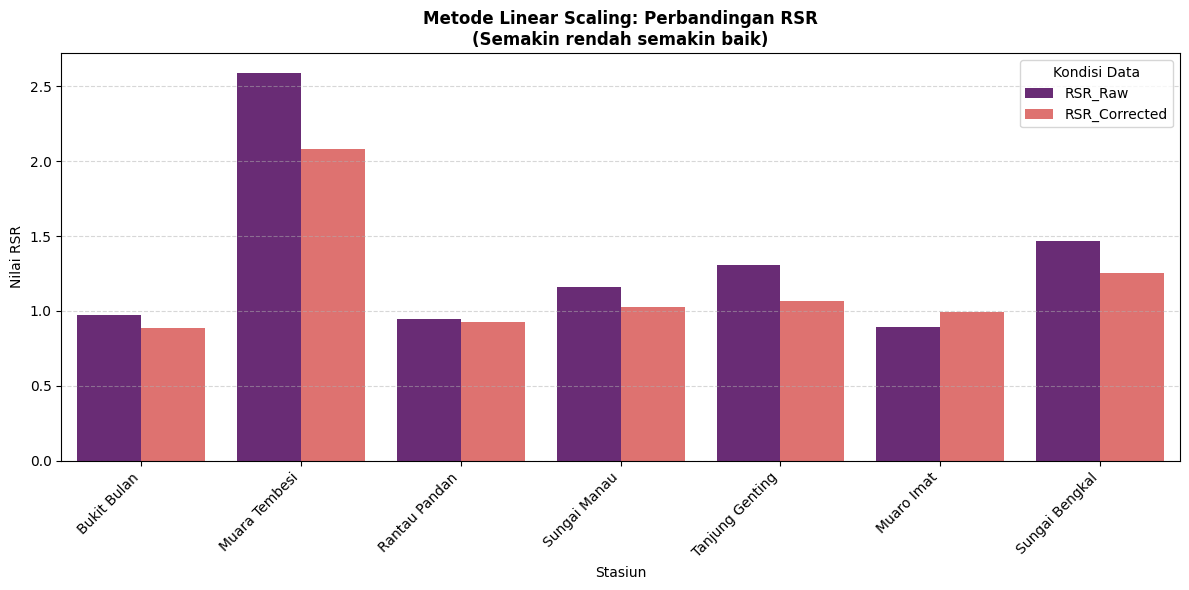

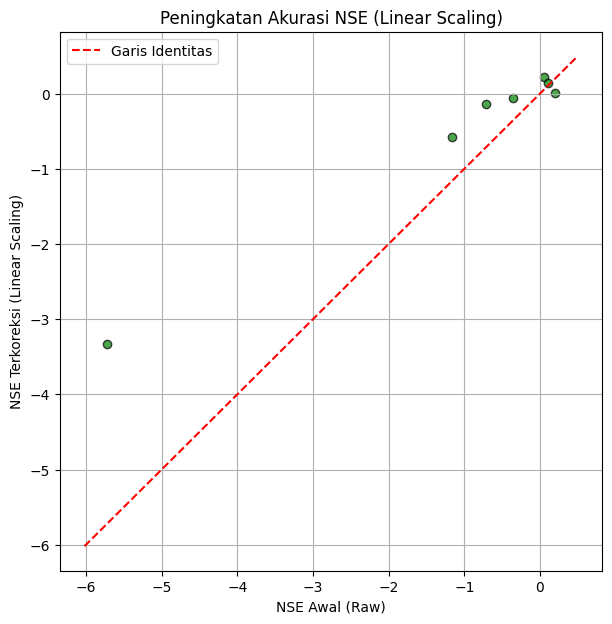

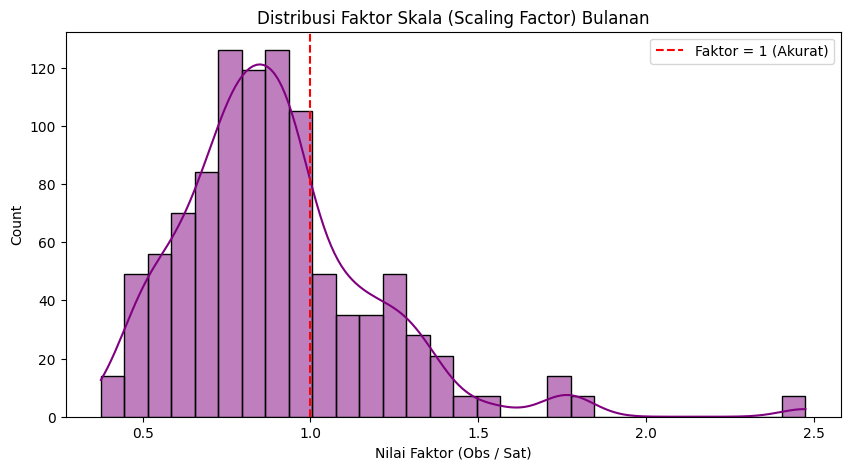

In [ ]:
# ==========================================
# BAGIAN 5: VISUALISASI
# ==========================================

# Grafik 1: Perbandingan RSR
plt.figure(figsize=(12, 6))
plot_data = summary.melt(id_vars='Stasiun', value_vars=['RSR_Raw', 'RSR_Corrected'])
sns.barplot(data=plot_data, x='Stasiun', y='value', hue='variable', palette='magma')
plt.title('Metode Linear Scaling: Perbandingan RSR\n(Semakin rendah semakin baik)', fontweight='bold')
plt.ylabel('Nilai RSR')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title="Kondisi Data")
plt.tight_layout()
plt.show()

# Grafik 2: Scatter Plot NSE
plt.figure(figsize=(7, 7))
plt.scatter(summary['NSE_Raw'], summary['NSE_Corrected'], alpha=0.7, c='green', edgecolors='k')
lims = [
    np.min([plt.xlim(), plt.ylim()]),
    np.max([plt.xlim(), plt.ylim()])
]
plt.plot(lims, lims, 'r--', label='Garis Identitas')
plt.xlabel('NSE Awal (Raw)')
plt.ylabel('NSE Terkoreksi (Linear Scaling)')
plt.title('Peningkatan Akurasi NSE (Linear Scaling)')
plt.legend()
plt.grid(True)
plt.show()

# Grafik 3: Distribusi Scaling Factor (Opsional - untuk analisis fisik)
# Melihat seberapa besar satelit dikoreksi (Factor > 1 = Satelit Underestimate, Factor < 1 = Satelit Overestimate)
plt.figure(figsize=(10, 5))
sns.histplot(validasi_df['Scaling_Factor'], bins=30, kde=True, color='purple')
plt.axvline(1, color='red', linestyle='--', label='Faktor = 1 (Akurat)')
plt.title('Distribusi Faktor Skala (Scaling Factor) Bulanan')
plt.xlabel('Nilai Faktor (Obs / Sat)')
plt.legend()
plt.show()